In [1]:
import numpy as np
import heapq

In [2]:
#解码数据集 函数为CIFAR-10提供的python3版本
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

#创建训练集和测试集
def CreatData(path):
    #依次加载CIFAR-10的5个batch_data,并将其合并为traindata和traindlabels
    x=[]
    y=[]
    for i in range(1,6):
        batch_path=path + 'data_batch_%d'%(i) #每个batch的地址
        batch_dict=unpickle(batch_path) #解码每个batch
        train_batch=batch_dict[b'data'].astype('float') #将每个batch的data部分以float形式存储于train_batch变量
        train_labels=np.array(batch_dict[b'labels']) #将每个batch的label部分以np.array的形式存储于train_labels变量
        x.append(train_batch)
        y.append(train_labels)
    #将5个训练样本batch(10000,3072)合并为(50000,3072)，标签合并为(50000,1)
    #np.concatenate默认axis=0:按行合并，axis=1则为:按列合并
    traindata=np.concatenate(x)
    trainlabels=np.concatenate(y)
    
    #加载测试集
    testpath=path + 'test_batch' #test_batch的地址
    test_dict=unpickle(testpath) #解码test_batch
    testdata=test_dict[b'data'].astype('float') #将test_dict的data部分以float形式存储于testdata变量
    testlabels=np.array(test_dict[b'labels']) #将test_dict的labels部分以np.array形式存储于testlabels变量
    
    #将训练集数据、训练集标签、测试集数据、测试集标签返回
    return traindata,trainlabels,testdata,testlabels

class MulticlassSVM:
    def __init__(self):
        pass
    def loaddata(self,traindata,trainlabels):
        #得到训练集图像数目
        self.imgnum = traindata.shape[0] #本CIFAR-10数据集读取后traindata.shape=(50000,3072)，50000为图像数目，3072为图像RGB三通道总像素数
        self.classnum = np.max(trainlabels) + 1 #统计数据集中有多少个类，CIFAR-10为10个分类(0至9)
        
        #为每张图片后添加1，以使得w*data[i,:].T+b转变为[w,b]*[data[i,:],1].T，从而在训练时用一个矩阵乘法同时更新权重w和偏置b
        data = traindata.copy() #复制一遍输入数据
        temp = np.ones((self.imgnum,1)) #创建一个增添的全为1的维度
        self.traindata = np.hstack((data,temp)) #traindata读到类里面，此时的self.traindata.shape=(50000,3073)
        self.trainlabels = trainlabels #将trainlabels全部读取到类里面
        
        w = np.random.rand(self.classnum,self.traindata.shape[1])#初始化一个随机的维度为(10,3073)的权重矩阵
        return w
    
    def train(self,w,delta,lambda_reg):
        #初始化本轮训练损失和权重w的负梯度
        Loss = 0
        dW=np.zeros(w.shape)
        for i in range(self.imgnum):
            #计算每一类的得分
            #np.dot(w,self.traindata[i,:].T).shape=(10,),np.sum(w*w,1)为按行求和,shape=(10,)
            #这里的scores为可能为每个分类的得分，维度为(10,)
            scores = np.dot(w,self.traindata[i,:].T)
            #第i张图片的正确分类的得分
            rightscores = scores[int(self.trainlabels[i])] #trainlabels[i]为第i张图片的分类，也就是scores里对应分类的下标
            
            #计算正则化的第i张图片的第j个分类得分对Li的贡献，维度为(10,)。注意这里的正则化被我拆分到了每一个分类里面分别计算
            Lij = scores - rightscores + delta + lambda_reg*np.sum(w*w,1) #np.sum(w*w,1)：对w按行求平方和
            #初始化每张图片的损失Li
            Li = 0
            for j in range(self.classnum):
                #错误分类与正确分类得分未达到边界时，迭代权重w
                if j != int(self.trainlabels[i]) and Lij[j] > 0:
                    Li += Lij[j]
                    dW[j,:] += self.traindata[i,:]
                    dW[int(self.trainlabels[i]),:] -= self.traindata[i,:]
            Loss += Li
        #计算本轮训练的平均损失和负梯度
        Loss /= self.imgnum
        dW /= self.imgnum
        return Loss,dW
                    
 
    def predict(self,w,testdata):
        #得到测试集总图片数，并保存到testimg_num内
        testimg_num = testdata.shape[0]
        
        #为每张图片后添加1，以使得w*data[i,:].T+b转变为[w,b]*[data[i,:],1].T，从而在训练时用一个矩阵乘法同时更新权重w和偏置b
        data = testdata.copy() #复制一遍输入数据
        temp = np.ones((testimg_num,1)) #创建一个增添的全为1的维度
        self.testdata = np.hstack((data,temp)) #testdata读到类里面，此时的self.testdata.shape=(10000,3073)
        
        #创建一个维度为(testimg_num，)的np.array，用于存储预测的标签
        predlabels = np.zeros(testimg_num, dtype = self.trainlabels.dtype)
        #遍历训练集
        for i in range(testimg_num):
            #计算测试图片各类别得分
            scores = np.dot(w,self.testdata[i,:].T)
            predlabels[i] = np.argmax(scores) # 记录下得分最高的类别标签
        #返回预测标签
        return predlabels

In [3]:
#读取训练集和测试集的数据和标签
traindata,trainlabels,testdata,testlabels = CreatData("D:/Personal_documents/DXY/code/LearningForML/cifar-10-batches-py/")

#实例化一个多类SVM的类
msvm = MulticlassSVM()
#调用类中的train函数训练(实则为将训练数据全部读取)
w = msvm.loaddata(traindata, trainlabels)

#设置超参数，训练次数trainnum，delta=1在正则化的条件下是安全的，正则化项的参数lambda_reg，学习率alpha
trainnum = 100
delta = 1
lambda_reg = 0.5
alpha = 0.0001

loss = np.zeros(trainnum)#初始化损失
predictaccuracy = np.zeros(trainnum)#初始化预测准确率，用于保存每一次训练后的准确率
for i in range(trainnum):
    loss[i],dw = msvm.train(w,delta,lambda_reg)#计算损失和梯度
    w -= alpha * dw#更新梯度
    #调用类中的predict函数预测标签
    testlabels_predict = msvm.predict(w,testdata)
    #比对测试集标签，计算准确率。
    predictaccuracy[i] = np.mean(testlabels_predict == testlabels)

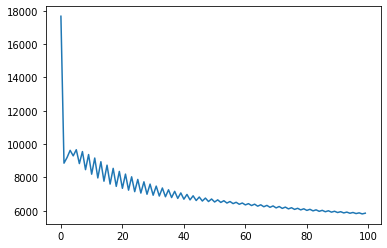

In [4]:
#作出每次训练后损失的图像
import matplotlib.pyplot as plt
x = np.zeros(trainnum)
for i in range(trainnum):
    x[i] = i
plt.plot(x,loss)

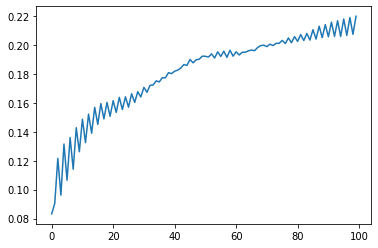

In [5]:
#作出每次训练后准确率的图像
plt.plot(x,predictaccuracy)